In [13]:
import numpy as np
np.bool = bool


In [14]:
# ================================================================================================
# EDA Part 1: Comprehensive Loan Data Analysis (Silver Layer)
# This analysis focuses on understanding loan performance, default patterns, and payment behaviors
# ================================================================================================

# ================================================================================================
# EDA Part 1: Comprehensive Loan Data Analysis with Rich Visualizations
# This analysis focuses on understanding loan performance, default patterns, and payment behaviors
# ================================================================================================

from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ================================================================================================
# SPARK SESSION INITIALIZATION
# ================================================================================================

print("Initializing Spark Session...")
print("-" * 30)

# Create Spark session
spark = SparkSession.builder \
    .appName("LoanDataEDA_Part1") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Set log level to reduce verbose output
spark.sparkContext.setLogLevel("WARN")

print("✅ Spark session initialized successfully!")
print(f"Spark version: {spark.version}")
print(f"Application name: {spark.sparkContext.appName}")

# ================================================================================================
# DATA LOADING SECTION
# ================================================================================================

print("Loading Silver Layer Data...")
print("-" * 30)

# Load all silver layer datasets
silver_dfs = {}

# Load loan data
print("Loading loan data...")
silver_dfs['loan'] = spark.read.parquet("datamart/silver/silver_loan")

# Load customer attributes data
print("Loading customer attributes data...")
silver_dfs['customer_attributes'] = spark.read.parquet("datamart/silver/silver_attributes")

# Load financial data
print("Loading financial data...")
silver_dfs['financial'] = spark.read.parquet("datamart/silver/silver_financials")

# Load clickstream aggregated data
print("Loading clickstream aggregated data...")
silver_dfs['clickstream_aggregated'] = spark.read.parquet("datamart/silver/silver_clickstream_aggregated")

# Load clickstream detailed data
print("Loading clickstream detailed data...")
silver_dfs['clickstream_detailed'] = spark.read.parquet("datamart/silver/silver_clickstream_detailed")

print(" All silver layer data loaded successfully!")
print(f"Available datasets: {list(silver_dfs.keys())}")

# Set the main dataset for this analysis
loan_df = silver_dfs['loan']

print("=" * 80)
print("LOAN DATA EXPLORATORY DATA ANALYSIS - PART 1")
print("=" * 80)


Initializing Spark Session...
------------------------------
✅ Spark session initialized successfully!
Spark version: 3.5.0
Application name: LoanDataEDA_Part1
Loading Silver Layer Data...
------------------------------
Loading loan data...
Loading customer attributes data...
Loading financial data...
Loading clickstream aggregated data...
Loading clickstream detailed data...
 All silver layer data loaded successfully!
Available datasets: ['loan', 'customer_attributes', 'financial', 'clickstream_aggregated', 'clickstream_detailed']
LOAN DATA EXPLORATORY DATA ANALYSIS - PART 1


In [15]:
# ================================================================================================
# 1. BASIC DATA OVERVIEW AND STRUCTURE
# ================================================================================================

print("\n1. BASIC DATA OVERVIEW")
print("-" * 40)

# Get basic dataset information
total_records = loan_df.count()
total_customers = loan_df.select("Customer_ID").distinct().count()
total_loans = loan_df.select("loan_id").distinct().count()
date_range = loan_df.select(min("snapshot_date").alias("min_date"), 
                           max("snapshot_date").alias("max_date")).collect()[0]

print(f"Total loan records: {total_records:,}")
print(f"Unique customers: {total_customers:,}")
print(f"Unique loans: {total_loans:,}")
print(f"Data date range: {date_range['min_date']} to {date_range['max_date']}")
print(f"Average records per customer: {total_records/total_customers:.1f}")
print(f"Average records per loan: {total_records/total_loans:.1f}")


1. BASIC DATA OVERVIEW
----------------------------------------
Total loan records: 137,500
Unique customers: 12,500
Unique loans: 12,500
Data date range: 2023-01-01 to 2025-11-01
Average records per customer: 11.0
Average records per loan: 11.0



2. LOAN PERFORMANCE AND DEFAULT ANALYSIS
--------------------------------------------------
Customer-level default rate: 28.82%
Loan-level default rate: 28.82%


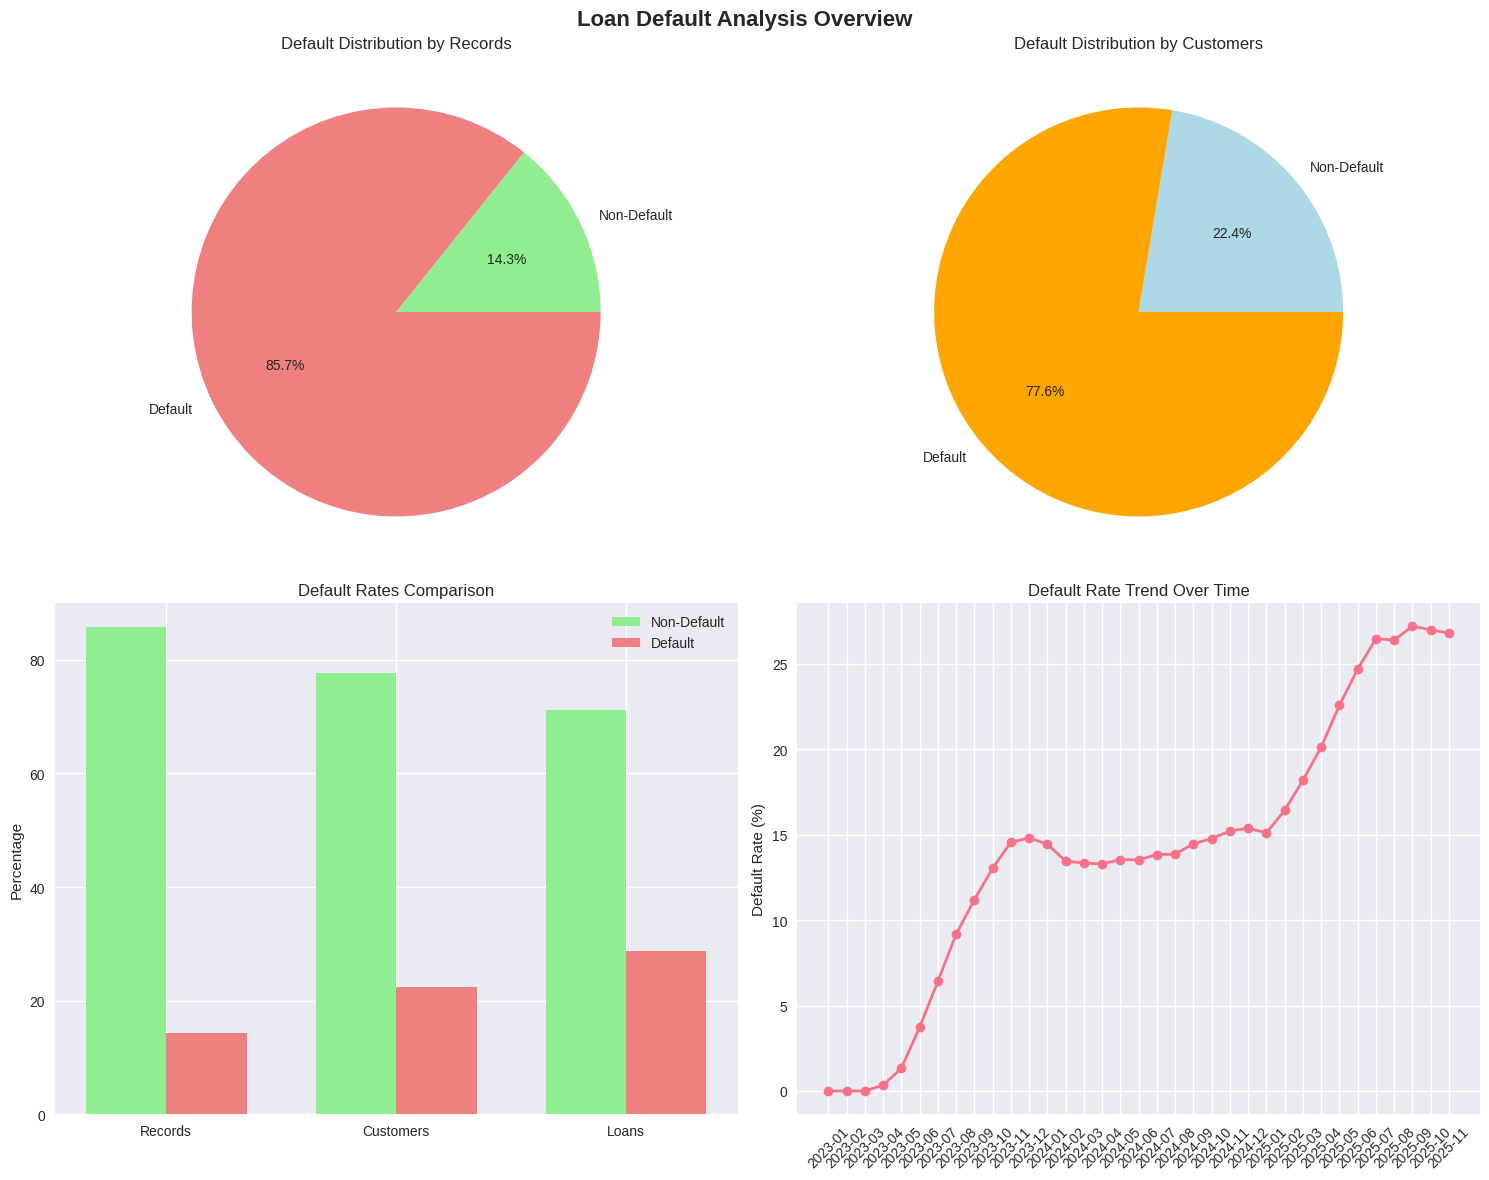

In [16]:
# ================================================================================================
# 2. DEFAULT ANALYSIS WITH VISUALIZATIONS
# ================================================================================================

print("\n2. LOAN PERFORMANCE AND DEFAULT ANALYSIS")
print("-" * 50)

# Calculate default statistics
default_stats = loan_df.groupBy("is_default").agg(
    count("*").alias("record_count"),
    countDistinct("Customer_ID").alias("unique_customers"),
    countDistinct("loan_id").alias("unique_loans")
).toPandas()

# Calculate rates
customer_default_rate = loan_df.filter(col("is_default") == True).select("Customer_ID").distinct().count() / total_customers * 100
loan_default_rate = loan_df.filter(col("is_default") == True).select("loan_id").distinct().count() / total_loans * 100

print(f"Customer-level default rate: {customer_default_rate:.2f}%")
print(f"Loan-level default rate: {loan_default_rate:.2f}%")

# Visualization 1: Default Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Loan Default Analysis Overview', fontsize=16, fontweight='bold')

# Default distribution by records
default_records = default_stats.set_index('is_default')['record_count']
axes[0,0].pie(default_records.values, labels=['Non-Default', 'Default'], autopct='%1.1f%%', 
              colors=['lightgreen', 'lightcoral'])
axes[0,0].set_title('Default Distribution by Records')

# Default distribution by customers
default_customers = default_stats.set_index('is_default')['unique_customers']
axes[0,1].pie(default_customers.values, labels=['Non-Default', 'Default'], autopct='%1.1f%%',
              colors=['lightblue', 'orange'])
axes[0,1].set_title('Default Distribution by Customers')

# Bar chart comparison
categories = ['Records', 'Customers', 'Loans']
default_pct = [
    default_records[True] / default_records.sum() * 100,
    default_customers[True] / default_customers.sum() * 100,
    loan_default_rate
]
non_default_pct = [100 - x for x in default_pct]

x = np.arange(len(categories))
width = 0.35
axes[1,0].bar(x - width/2, non_default_pct, width, label='Non-Default', color='lightgreen')
axes[1,0].bar(x + width/2, default_pct, width, label='Default', color='lightcoral')
axes[1,0].set_ylabel('Percentage')
axes[1,0].set_title('Default Rates Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(categories)
axes[1,0].legend()

# Default rate trend over time
monthly_default = loan_df.withColumn("year_month", date_format(col("snapshot_date"), "yyyy-MM")) \
    .groupBy("year_month").agg(
        (sum(when(col("is_default") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate")
    ).orderBy("year_month").toPandas()

axes[1,1].plot(monthly_default['year_month'], monthly_default['default_rate'], marker='o', linewidth=2)
axes[1,1].set_title('Default Rate Trend Over Time')
axes[1,1].set_ylabel('Default Rate (%)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



3. PAYMENT BEHAVIOR PATTERNS
-----------------------------------


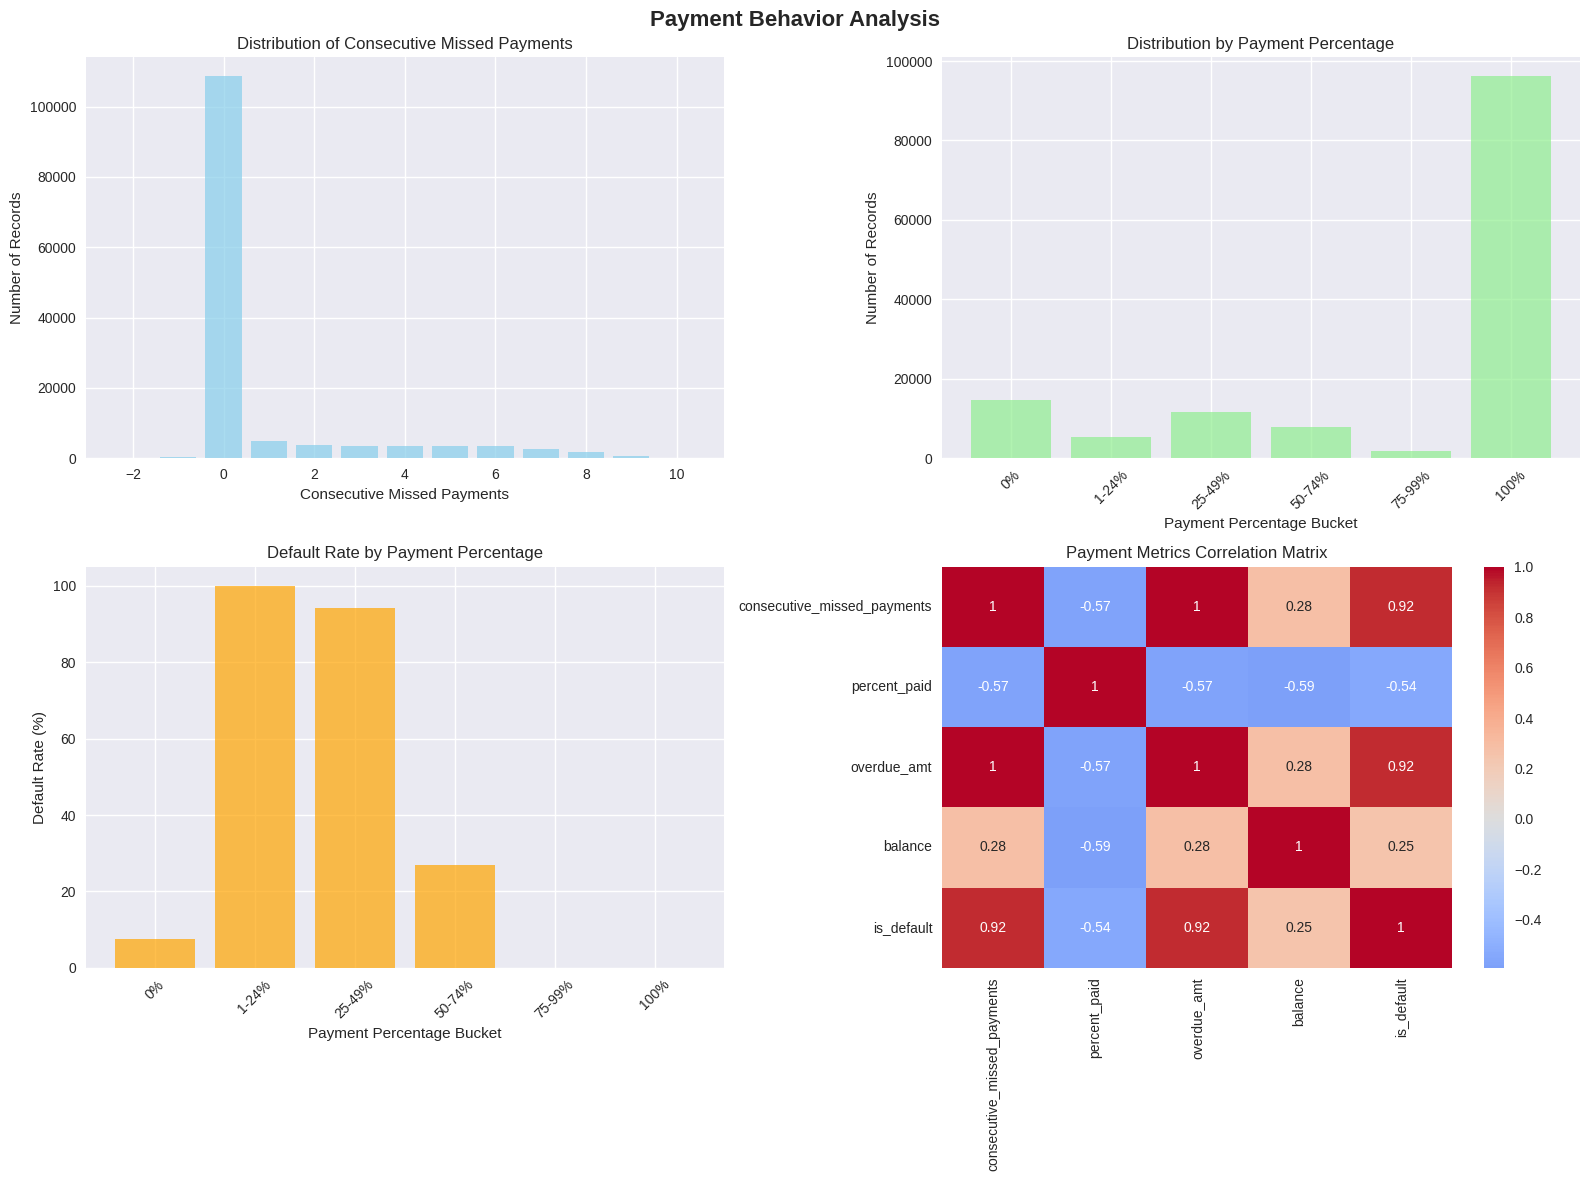

In [25]:
# ================================================================================================
# 3. PAYMENT BEHAVIOR ANALYSIS WITH VISUALIZATIONS
# ================================================================================================

print("\n3. PAYMENT BEHAVIOR PATTERNS")
print("-" * 35)

# Consecutive missed payments analysis
missed_payments_data = loan_df.groupBy("consecutive_missed_payments").agg(
    count("*").alias("record_count"),
    countDistinct("Customer_ID").alias("unique_customers")
).orderBy("consecutive_missed_payments").toPandas()

# Payment percentage analysis
payment_buckets_df = loan_df.withColumn(
    "payment_bucket",
    when(col("percent_paid") == 0, "0%")
    .when(col("percent_paid") < 25, "1-24%")
    .when(col("percent_paid") < 50, "25-49%")
    .when(col("percent_paid") < 75, "50-74%")
    .when(col("percent_paid") < 100, "75-99%")
    .otherwise("100%")
).groupBy("payment_bucket").agg(
    count("*").alias("record_count"),
    (sum(when(col("is_default") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate")
).toPandas()

# Visualization 2: Payment Behavior Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Payment Behavior Analysis', fontsize=16, fontweight='bold')

# Consecutive missed payments distribution
axes[0,0].bar(missed_payments_data['consecutive_missed_payments'], 
              missed_payments_data['record_count'], color='skyblue', alpha=0.7)
axes[0,0].set_title('Distribution of Consecutive Missed Payments')
axes[0,0].set_xlabel('Consecutive Missed Payments')
axes[0,0].set_ylabel('Number of Records')

# Payment percentage buckets
bucket_order = ["0%", "1-24%", "25-49%", "50-74%", "75-99%", "100%"]
payment_buckets_ordered = payment_buckets_df.set_index('payment_bucket').reindex(bucket_order)
axes[0,1].bar(range(len(bucket_order)), payment_buckets_ordered['record_count'], 
              color='lightgreen', alpha=0.7)
axes[0,1].set_title('Distribution by Payment Percentage')
axes[0,1].set_xlabel('Payment Percentage Bucket')
axes[0,1].set_ylabel('Number of Records')
axes[0,1].set_xticks(range(len(bucket_order)))
axes[0,1].set_xticklabels(bucket_order, rotation=45)

# Default rate by payment bucket
axes[1,0].bar(range(len(bucket_order)), payment_buckets_ordered['default_rate'], 
              color='orange', alpha=0.7)
axes[1,0].set_title('Default Rate by Payment Percentage')
axes[1,0].set_xlabel('Payment Percentage Bucket')
axes[1,0].set_ylabel('Default Rate (%)')
axes[1,0].set_xticks(range(len(bucket_order)))
axes[1,0].set_xticklabels(bucket_order, rotation=45)

# Correlation heatmap between payment metrics
correlation_data = loan_df.select("consecutive_missed_payments", "percent_paid", "overdue_amt", 
                                  "balance", "is_default").toPandas()
correlation_data['is_default'] = correlation_data['is_default'].astype(int)
correlation_matrix = correlation_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Payment Metrics Correlation Matrix')

plt.tight_layout()
plt.show()



4. FINANCIAL METRICS ANALYSIS
-----------------------------------


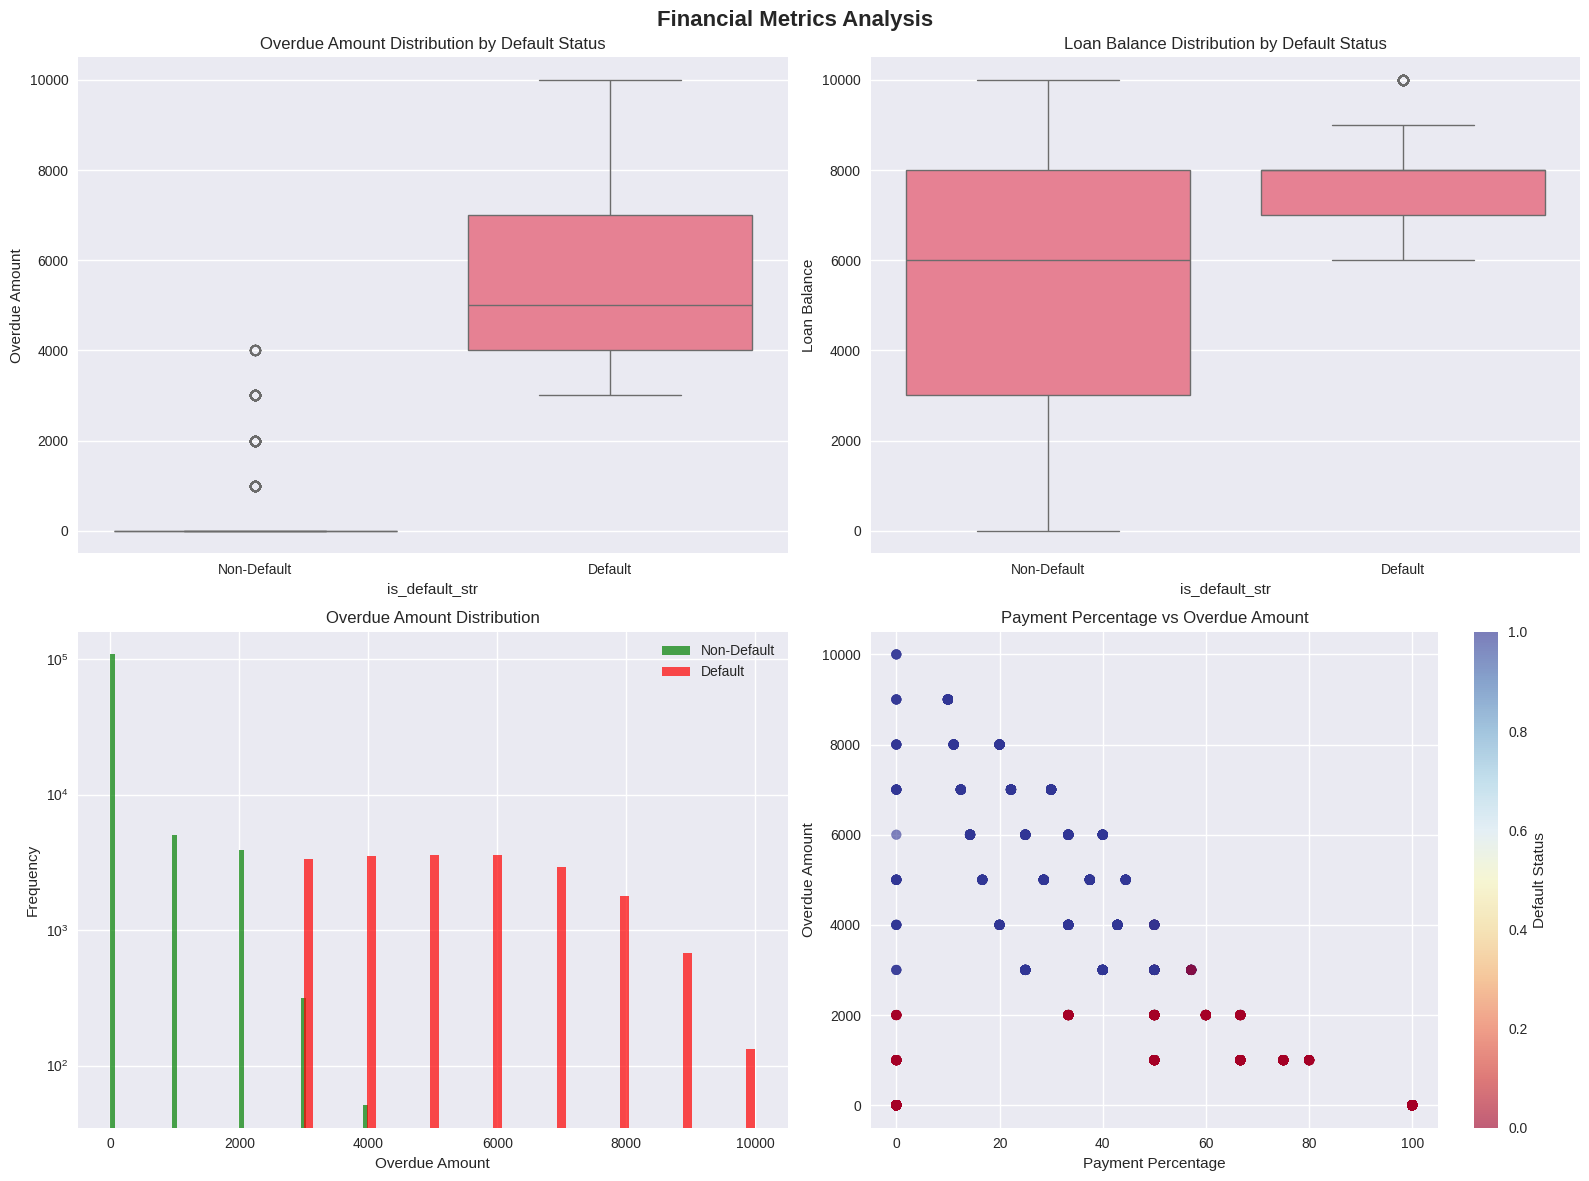

In [20]:
# ================================================================================================
# 4. FINANCIAL METRICS ANALYSIS WITH VISUALIZATIONS
# ================================================================================================

print("\n4. FINANCIAL METRICS ANALYSIS")
print("-" * 35)

# Get financial data for visualization
financial_data = loan_df.select("is_default", "overdue_amt", "balance", "percent_paid").toPandas()
financial_data['is_default_str'] = financial_data['is_default'].map({True: 'Default', False: 'Non-Default'})

# Visualization 3: Financial Metrics Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Financial Metrics Analysis', fontsize=16, fontweight='bold')

# Overdue amount distribution by default status
sns.boxplot(data=financial_data, x='is_default_str', y='overdue_amt', ax=axes[0,0])
axes[0,0].set_title('Overdue Amount Distribution by Default Status')
axes[0,0].set_ylabel('Overdue Amount')

# Balance distribution by default status
sns.boxplot(data=financial_data, x='is_default_str', y='balance', ax=axes[0,1])
axes[0,1].set_title('Loan Balance Distribution by Default Status')
axes[0,1].set_ylabel('Loan Balance')

# Overdue amount histogram
axes[1,0].hist(financial_data[financial_data['is_default']==False]['overdue_amt'], 
               bins=50, alpha=0.7, label='Non-Default', color='green')
axes[1,0].hist(financial_data[financial_data['is_default']==True]['overdue_amt'], 
               bins=50, alpha=0.7, label='Default', color='red')
axes[1,0].set_title('Overdue Amount Distribution')
axes[1,0].set_xlabel('Overdue Amount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].set_yscale('log')

# Payment percentage vs overdue amount scatter
# Use Python's built-in min function by importing it explicitly
from builtins import min as builtin_min
sample_size = builtin_min(5000, len(financial_data))
sample_data = financial_data.sample(n=sample_size)  # Sample for better visualization
scatter = axes[1,1].scatter(sample_data['percent_paid'], sample_data['overdue_amt'], 
                           c=sample_data['is_default'].astype(int), alpha=0.6, cmap='RdYlBu')
axes[1,1].set_title('Payment Percentage vs Overdue Amount')
axes[1,1].set_xlabel('Payment Percentage')
axes[1,1].set_ylabel('Overdue Amount')
plt.colorbar(scatter, ax=axes[1,1], label='Default Status')

plt.tight_layout()
plt.show()


5. TEMPORAL PATTERNS AND TRENDS
-----------------------------------


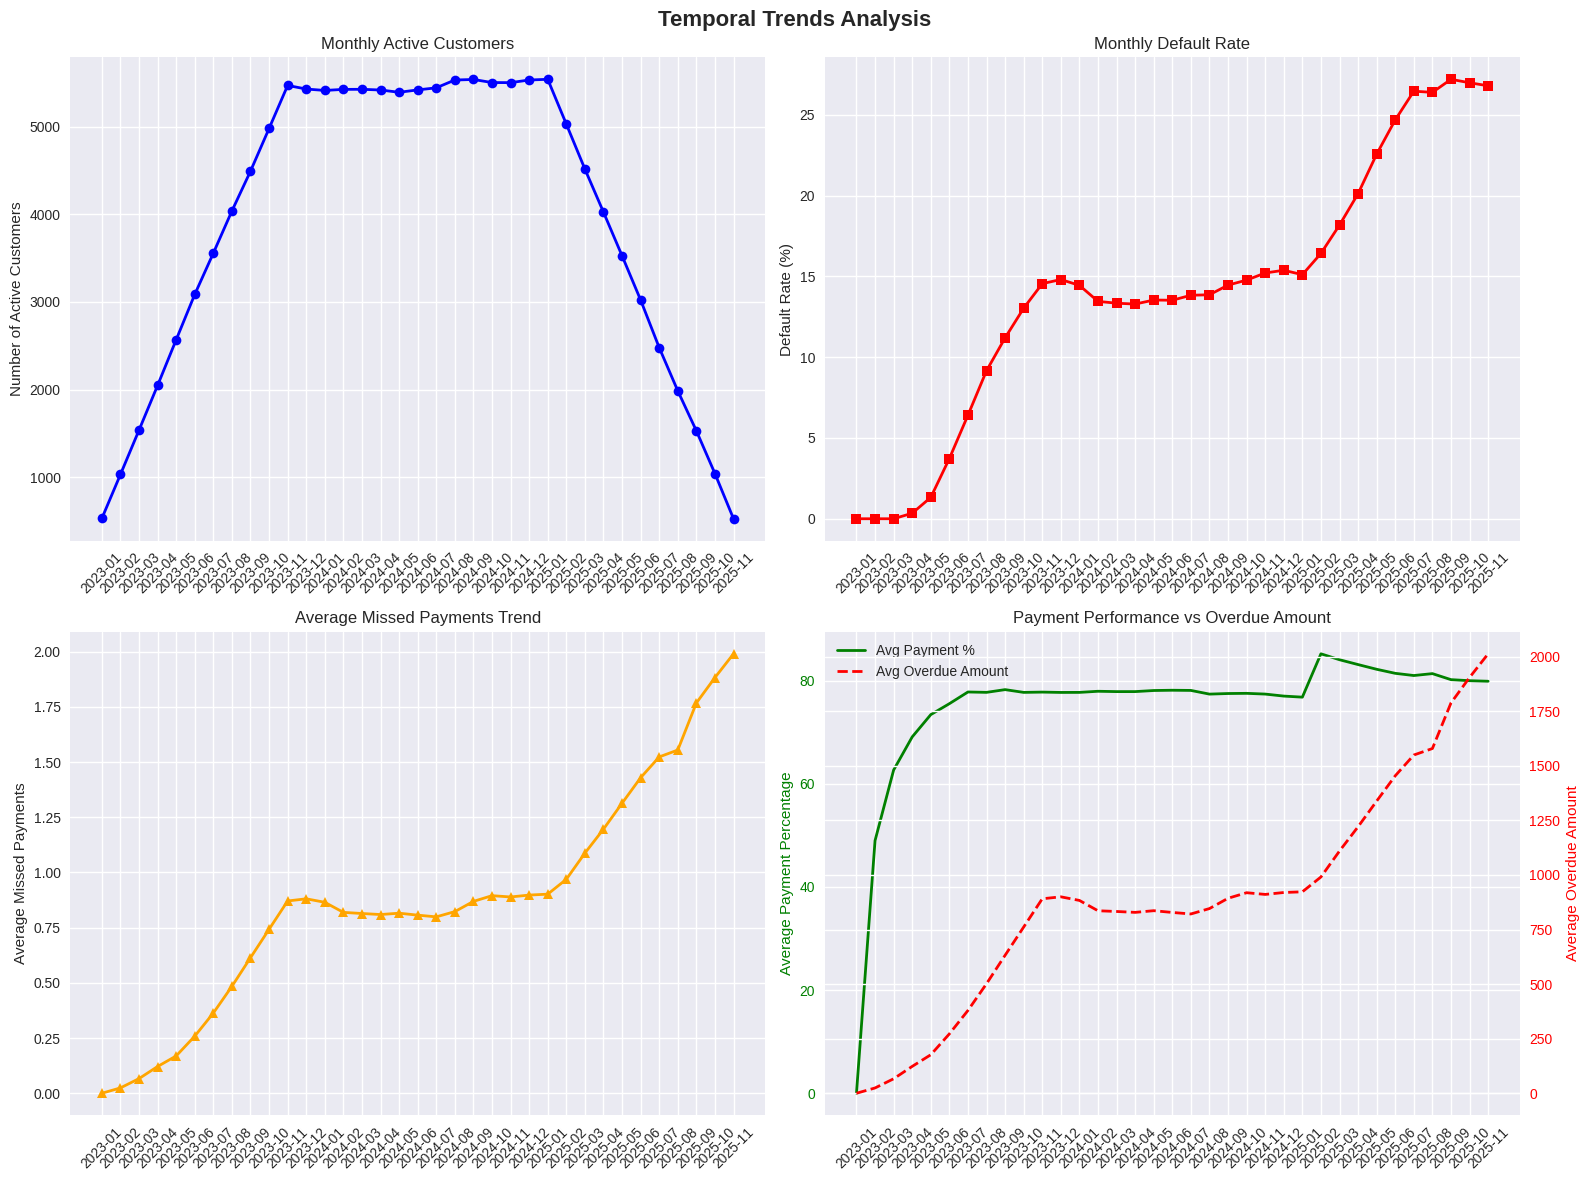

In [21]:
# ================================================================================================
# 5. TEMPORAL ANALYSIS WITH VISUALIZATIONS
# ================================================================================================

print("\n5. TEMPORAL PATTERNS AND TRENDS")
print("-" * 35)

# Monthly trends
monthly_data = loan_df.withColumn("year_month", date_format(col("snapshot_date"), "yyyy-MM")) \
    .groupBy("year_month").agg(
        count("*").alias("total_records"),
        countDistinct("Customer_ID").alias("active_customers"),
        avg("consecutive_missed_payments").alias("avg_missed_payments"),
        avg("percent_paid").alias("avg_percent_paid"),
        avg("overdue_amt").alias("avg_overdue_amt"),
        (sum(when(col("is_default") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate")
    ).orderBy("year_month").toPandas()

# Visualization 4: Temporal Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Trends Analysis', fontsize=16, fontweight='bold')

# Monthly active customers
axes[0,0].plot(monthly_data['year_month'], monthly_data['active_customers'], 
               marker='o', linewidth=2, color='blue')
axes[0,0].set_title('Monthly Active Customers')
axes[0,0].set_ylabel('Number of Active Customers')
axes[0,0].tick_params(axis='x', rotation=45)

# Monthly default rate
axes[0,1].plot(monthly_data['year_month'], monthly_data['default_rate'], 
               marker='s', linewidth=2, color='red')
axes[0,1].set_title('Monthly Default Rate')
axes[0,1].set_ylabel('Default Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# Average missed payments trend
axes[1,0].plot(monthly_data['year_month'], monthly_data['avg_missed_payments'], 
               marker='^', linewidth=2, color='orange')
axes[1,0].set_title('Average Missed Payments Trend')
axes[1,0].set_ylabel('Average Missed Payments')
axes[1,0].tick_params(axis='x', rotation=45)

# Multiple metrics on same plot
ax2 = axes[1,1]
line1 = ax2.plot(monthly_data['year_month'], monthly_data['avg_percent_paid'], 
                 'g-', linewidth=2, label='Avg Payment %')
ax2.set_ylabel('Average Payment Percentage', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.tick_params(axis='x', rotation=45)

ax3 = ax2.twinx()
line2 = ax3.plot(monthly_data['year_month'], monthly_data['avg_overdue_amt'], 
                 'r--', linewidth=2, label='Avg Overdue Amount')
ax3.set_ylabel('Average Overdue Amount', color='r')
ax3.tick_params(axis='y', labelcolor='r')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
axes[1,1].set_title('Payment Performance vs Overdue Amount')

plt.tight_layout()
plt.show()

In [22]:
# ================================================================================================
# 6. SUMMARY STATISTICS TABLE
# ================================================================================================

print("\n6. KEY SUMMARY STATISTICS")
print("-" * 30)

# Create summary statistics
summary_stats = loan_df.agg(
    count("*").alias("total_records"),
    countDistinct("Customer_ID").alias("unique_customers"),
    countDistinct("loan_id").alias("unique_loans"),
    avg("consecutive_missed_payments").alias("avg_missed_payments"),
    stddev("consecutive_missed_payments").alias("stddev_missed_payments"),
    avg("percent_paid").alias("avg_percent_paid"),
    stddev("percent_paid").alias("stddev_percent_paid"),
    avg("overdue_amt").alias("avg_overdue_amt"),
    stddev("overdue_amt").alias("stddev_overdue_amt"),
    avg("balance").alias("avg_balance"),
    stddev("balance").alias("stddev_balance"),
    (sum(when(col("is_default") == True, 1).otherwise(0)) / count("*") * 100).alias("overall_default_rate")
).collect()[0]

print("OVERALL LOAN PORTFOLIO SUMMARY:")
print(f"• Total Records: {summary_stats['total_records']:,}")
print(f"• Unique Customers: {summary_stats['unique_customers']:,}")
print(f"• Unique Loans: {summary_stats['unique_loans']:,}")
print(f"• Overall Default Rate: {summary_stats['overall_default_rate']:.2f}%")
print(f"• Average Missed Payments: {summary_stats['avg_missed_payments']:.2f} ± {summary_stats['stddev_missed_payments']:.2f}")
print(f"• Average Payment Percentage: {summary_stats['avg_percent_paid']:.2f}% ± {summary_stats['stddev_percent_paid']:.2f}%")
print(f"• Average Overdue Amount: ${summary_stats['avg_overdue_amt']:,.2f} ± ${summary_stats['stddev_overdue_amt']:,.2f}")
print(f"• Average Loan Balance: ${summary_stats['avg_balance']:,.2f} ± ${summary_stats['stddev_balance']:,.2f}")

print("\n" + "=" * 80)
print("END OF LOAN DATA ANALYSIS - PART 1")
print("Next: Run EDA Part 2 for Customer Attributes & Financial Data Analysis")
print("=" * 80)


6. KEY SUMMARY STATISTICS
------------------------------
OVERALL LOAN PORTFOLIO SUMMARY:
• Total Records: 137,500
• Unique Customers: 12,500
• Unique Loans: 12,500
• Overall Default Rate: 14.26%
• Average Missed Payments: 0.85 ± 1.99
• Average Payment Percentage: 77.74% ± 36.41%
• Average Overdue Amount: $871.91 ± $2,002.67
• Average Loan Balance: $5,871.91 ± $3,070.78

END OF LOAN DATA ANALYSIS - PART 1
Next: Run EDA Part 2 for Customer Attributes & Financial Data Analysis


In [29]:
# 查看Gold层数据的所有列名
print("Gold Layer 数据的所有列名:")
for i, col_name in enumerate(gold_df.columns):
    print(f"{i+1:2d}. {col_name}")

Gold Layer 数据的所有列名:
 1. Customer_ID
 2. has_clickstream_data
 3. age
 4. occupation
 5. is_valid_age
 6. annual_income
 7. Monthly_Inhand_Salary
 8. Num_Bank_Accounts
 9. Num_Credit_Card
10. Interest_Rate
11. Credit_Utilization_Ratio
12. credit_history_total_months
13. outstanding_debt
14. num_delayed_payments
15. credit_mix
16. payment_behavior_spent_level
17. payment_behavior_value_level
18. fe_1_mean
19. fe_2_mean
20. fe_3_mean
21. fe_4_mean
22. fe_5_mean
23. fe_1_stddev
24. fe_2_stddev
25. fe_3_stddev
26. fe_4_stddev
27. fe_5_stddev
28. fe_1_outlier_count
29. fe_2_outlier_count
30. fe_3_outlier_count
31. fe_4_outlier_count
32. fe_5_outlier_count
33. record_count
34. clickstream_features_imputed
35. total_loans
36. num_defaulted_loans
37. avg_missed_payments
38. max_missed_payments
39. avg_percent_paid
40. max_overdue_amt
41. min_balance
42. has_defaulted
43. default_risk_score
44. gold_process_timestamp


Loading Gold Layer Feature Data...
----------------------------------------
Gold layer data loaded successfully!
Dataset Overview:
   • Total customers: 12,500
   • Total features: 44

GOLD LAYER COMPREHENSIVE EXPLORATORY DATA ANALYSIS

1. TARGET VARIABLE ANALYSIS
--------------------------------------------------
Target Variable Distribution:
   has_defaulted  customer_count  avg_risk_score  stddev_risk_score  \
0           True            3602       108.34231           9.084914   
1          False            8898        11.86615           5.843041   

   min_risk_score  max_risk_score  
0              74             120  
1               0              35  

 Key Metrics:
   • Overall default rate: 28.82%
   • Total defaulted customers: 3,602
   • Total non-defaulted customers: 8,898


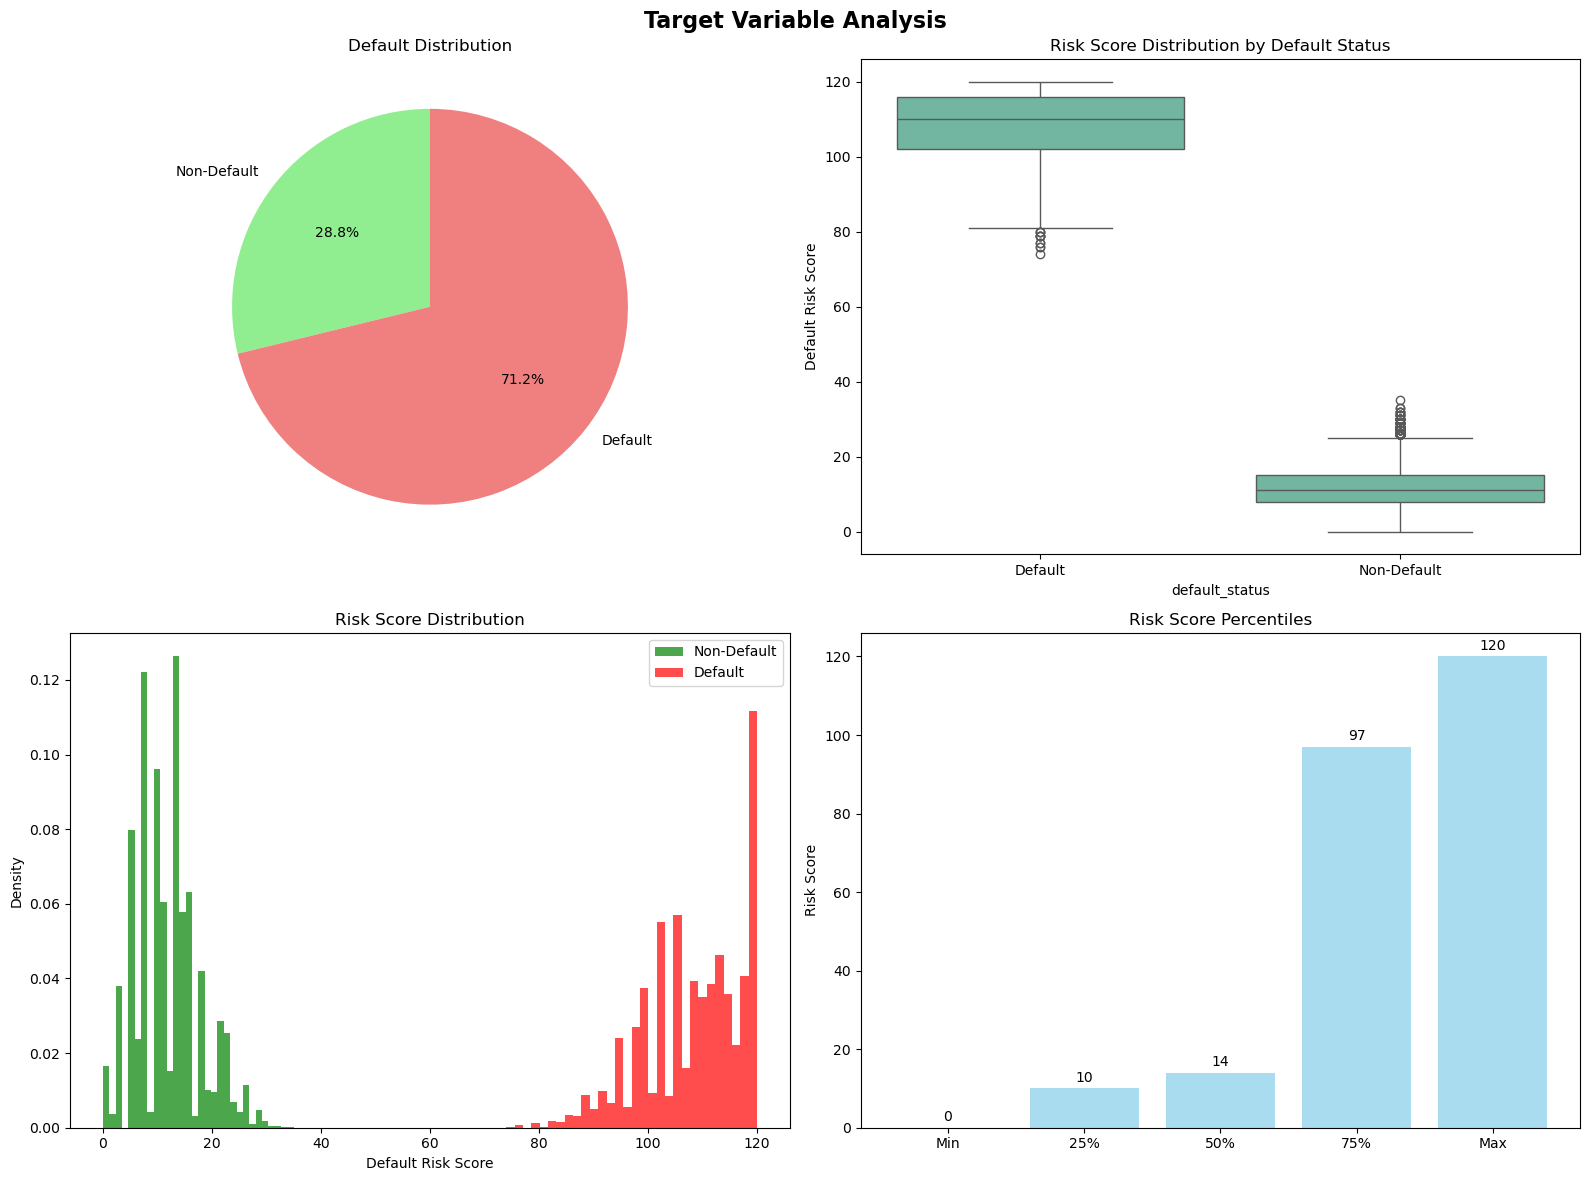


2.DEMOGRAPHIC AND CUSTOMER ATTRIBUTES ANALYSIS
------------------------------------------------------------
Age Group Analysis:
  age_group  customer_count     avg_income  default_rate  avg_risk_score
0     18-24            2963  123972.027386     32.534593       44.438407
1     25-34            3536  152313.160960     31.221719       42.183824
2     35-44            3500  157107.407067     30.028571       41.246286
3     45-54            1917  228821.368169     18.727178       27.529995
4       55+             584  215448.570146     21.232877       30.589041

Top 10 Occupations Analysis:
      occupation  customer_count     avg_income  default_rate  avg_risk_score
0        Unknown             880  101921.728352     28.522727       39.270455
1         Lawyer             828  169695.821534     26.570048       37.650966
2      Architect             795  160398.591862     27.295597       37.880503
3       Engineer             793  142876.474054     29.508197       40.534678
4     Account

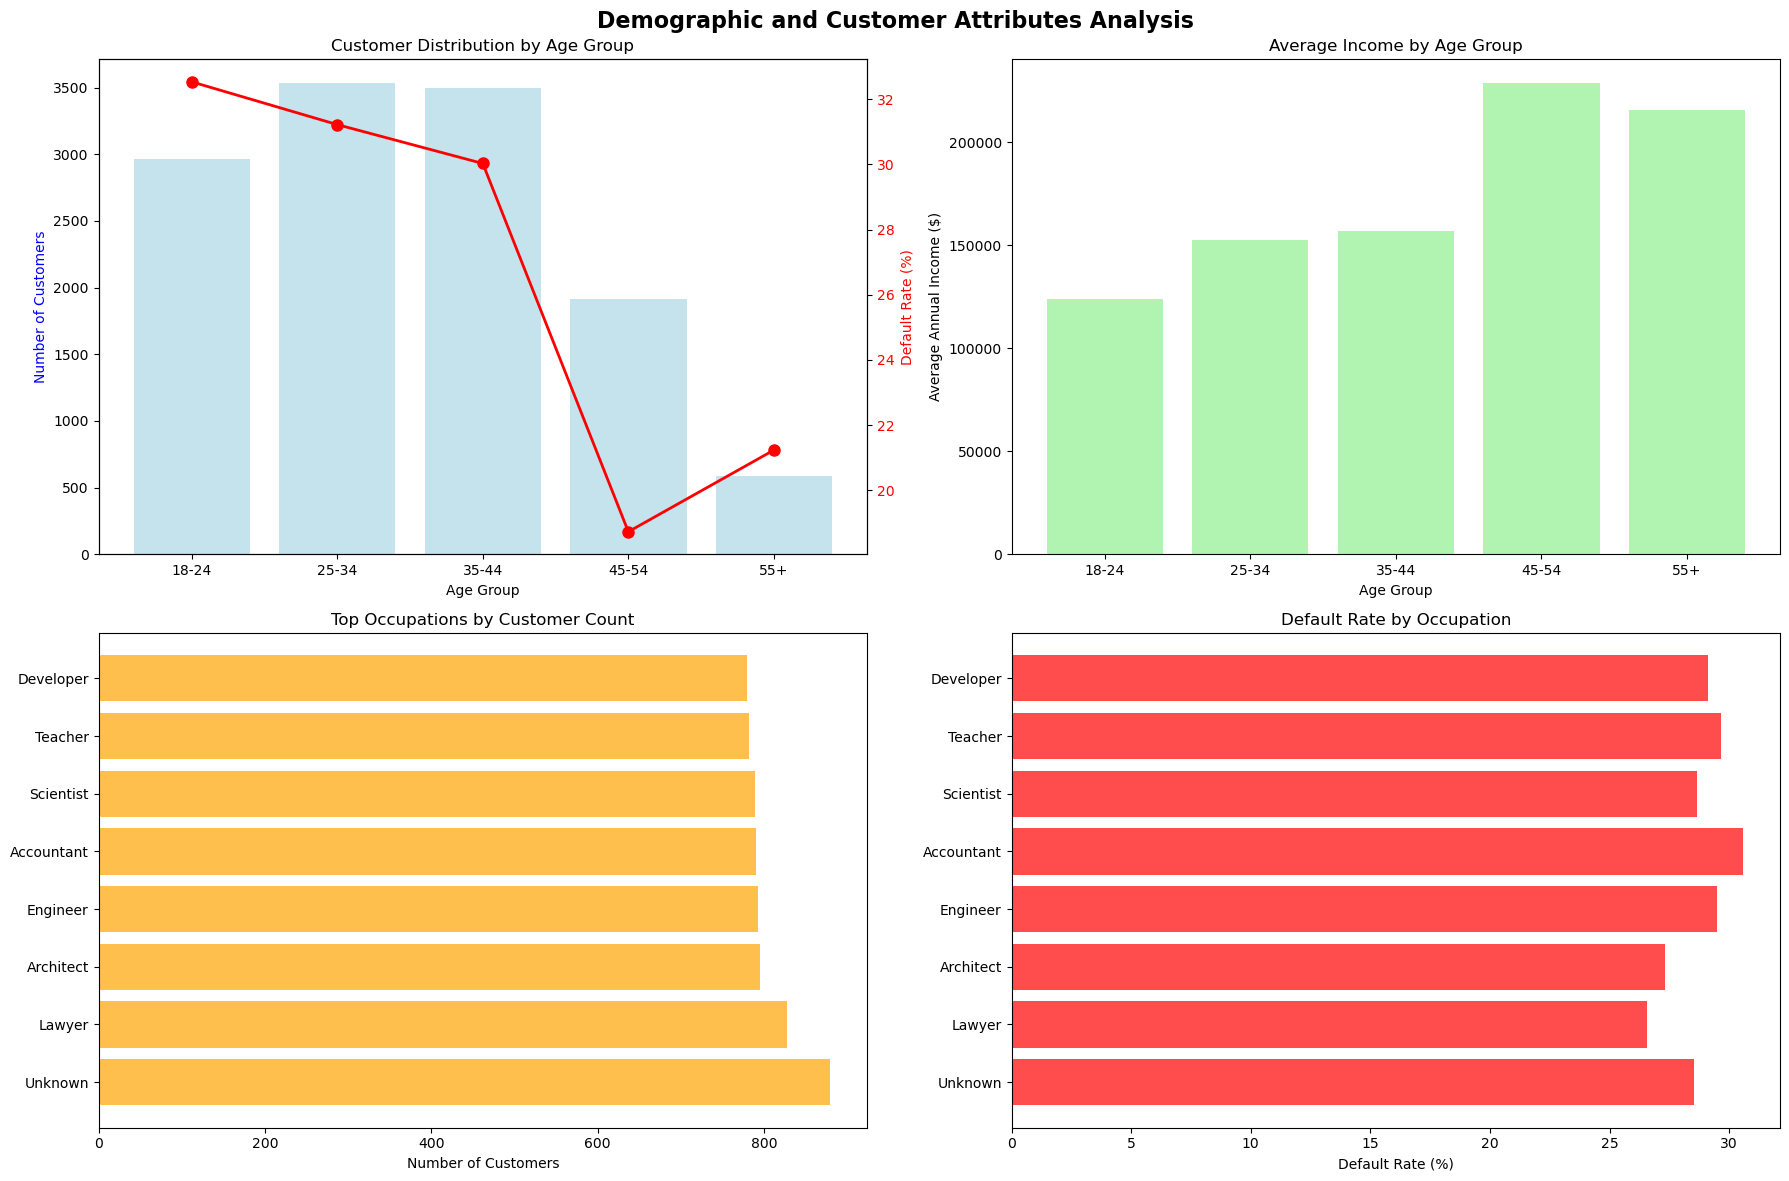


3.FINANCIAL HEALTH ANALYSIS
----------------------------------------
Income Bucket Analysis:
  income_bucket  customer_count  avg_credit_util     avg_debt  default_rate
0   $50K - $75K            2023        32.374913  1628.820692     32.822541
1   $30K - $50K            2760        32.018526  1356.914112     27.644928
2        < $30K            4765        31.638544  1699.148512     34.816369
3       > $100K            1695        34.373270   790.447286     15.516224
4  $75K - $100K            1257        32.999101  1075.033158     20.127287

Credit Mix Analysis:
  credit_mix  customer_count     avg_income  avg_credit_util  default_rate
0       GOOD            3032  192098.548959        32.967509     15.864116
1    UNKNOWN            2611  148789.225887        32.285884     27.767139
2        BAD            2360  154998.469333        31.790084     56.144068
3   STANDARD            4497  151996.675544        32.262681     23.815877


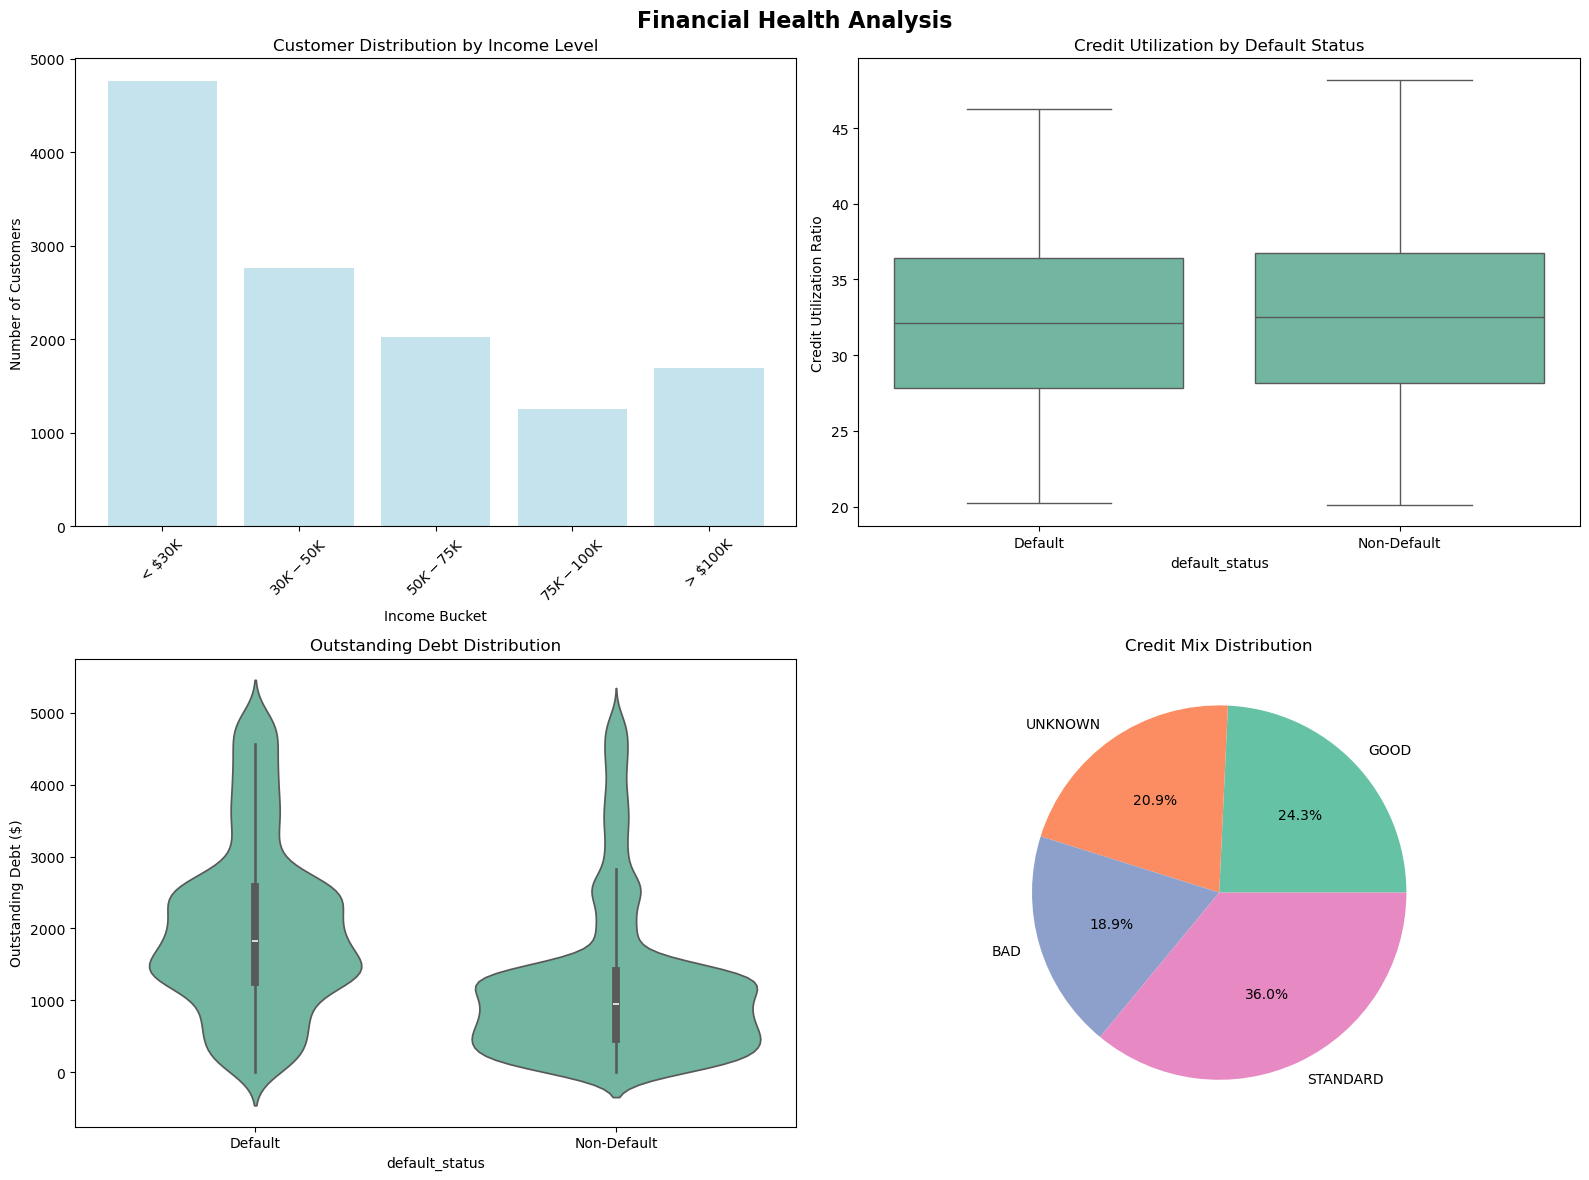


4. 🖱️ BEHAVIORAL FEATURES ANALYSIS
----------------------------------------
Clickstream Data Coverage Analysis:
   has_clickstream_data  customer_count     avg_income  default_rate  \
0                  True            8974  161740.513065     28.872298   
1                 False            3526  161315.241785     28.672717   

   avg_risk_score  
0       39.689548  
1       39.608622  


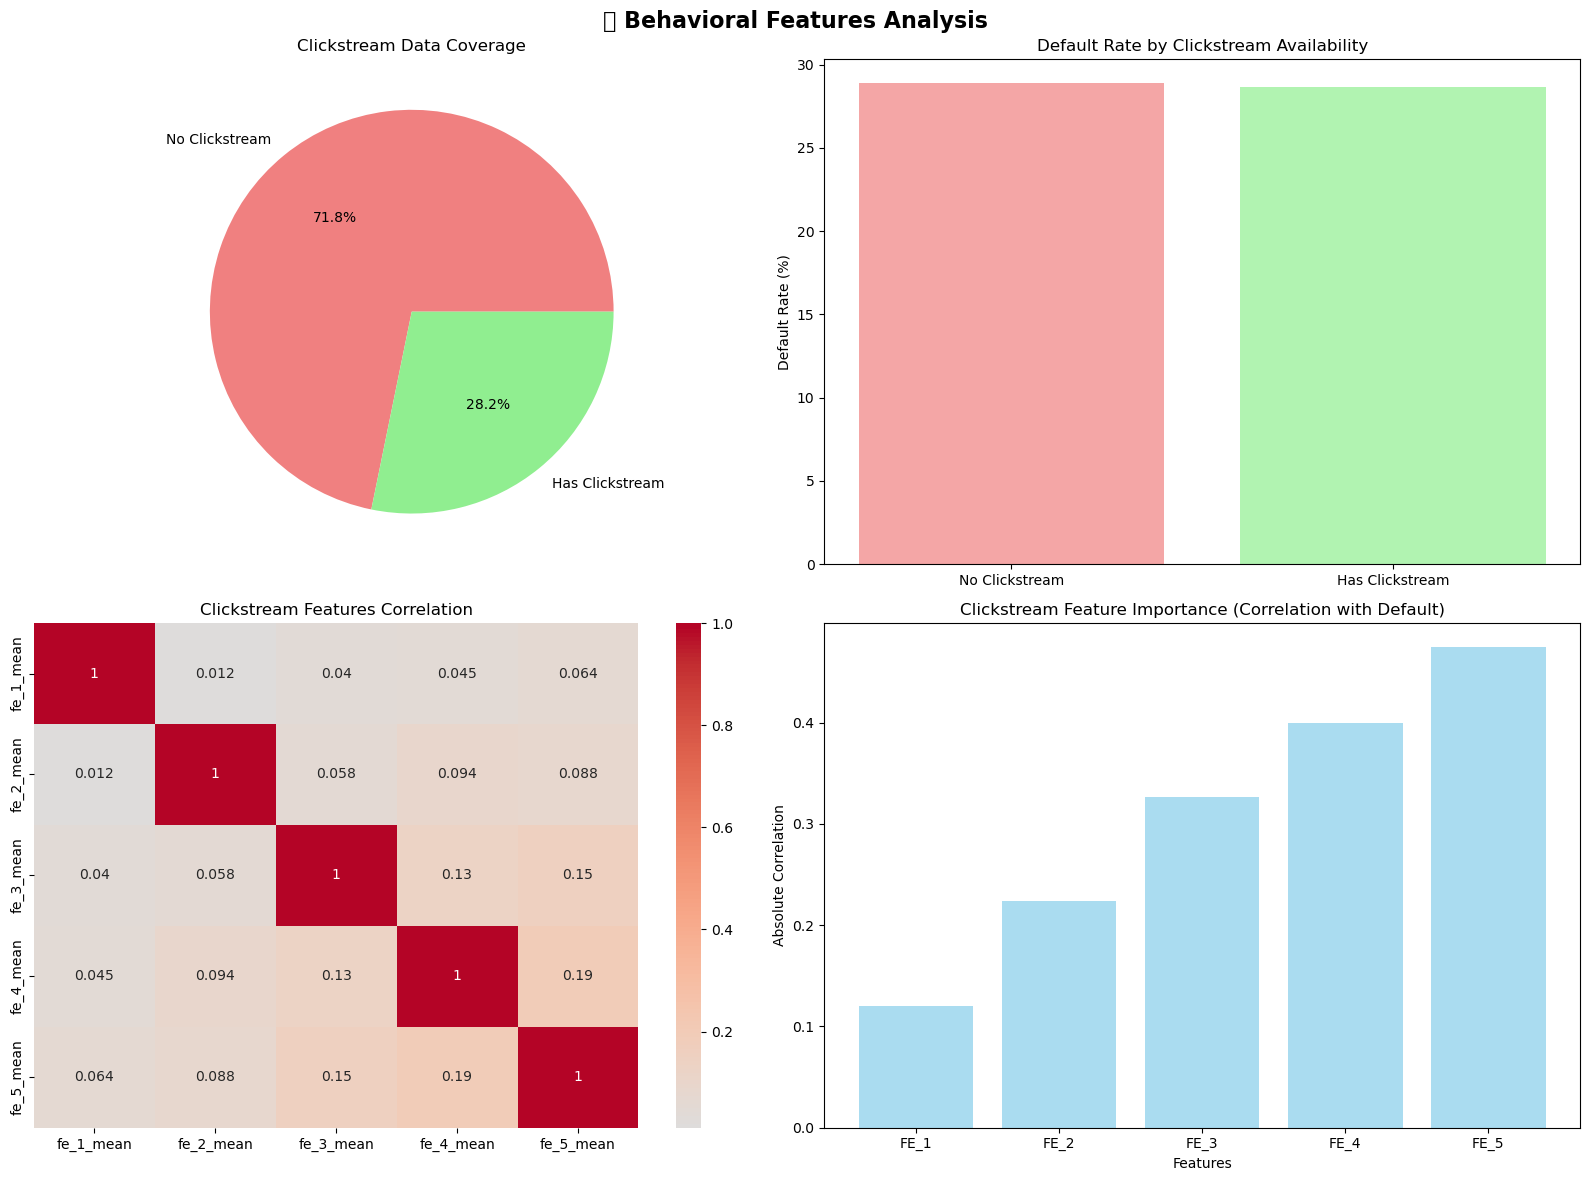


5. LOAN PORTFOLIO ANALYSIS
-----------------------------------
Loan Portfolio Analysis:
   total_loans  customer_count  avg_defaulted_loans  avg_max_missed_payments  \
0            1           12500              1.56808                   2.1408   

   default_rate  
0        28.816  

Payment Behavior Analysis:
  payment_behavior_spent_level payment_behavior_value_level  customer_count  \
0                      UNKNOWN                      UNKNOWN             998   
1                         HIGH                       MEDIUM            2242   
2                         HIGH                        SMALL            1389   
3                          LOW                       MEDIUM            1686   
4                         HIGH                        LARGE            1683   
5                          LOW                        SMALL            3202   
6                          LOW                        LARGE            1300   

   default_rate  avg_risk_score  
0     28.957916    

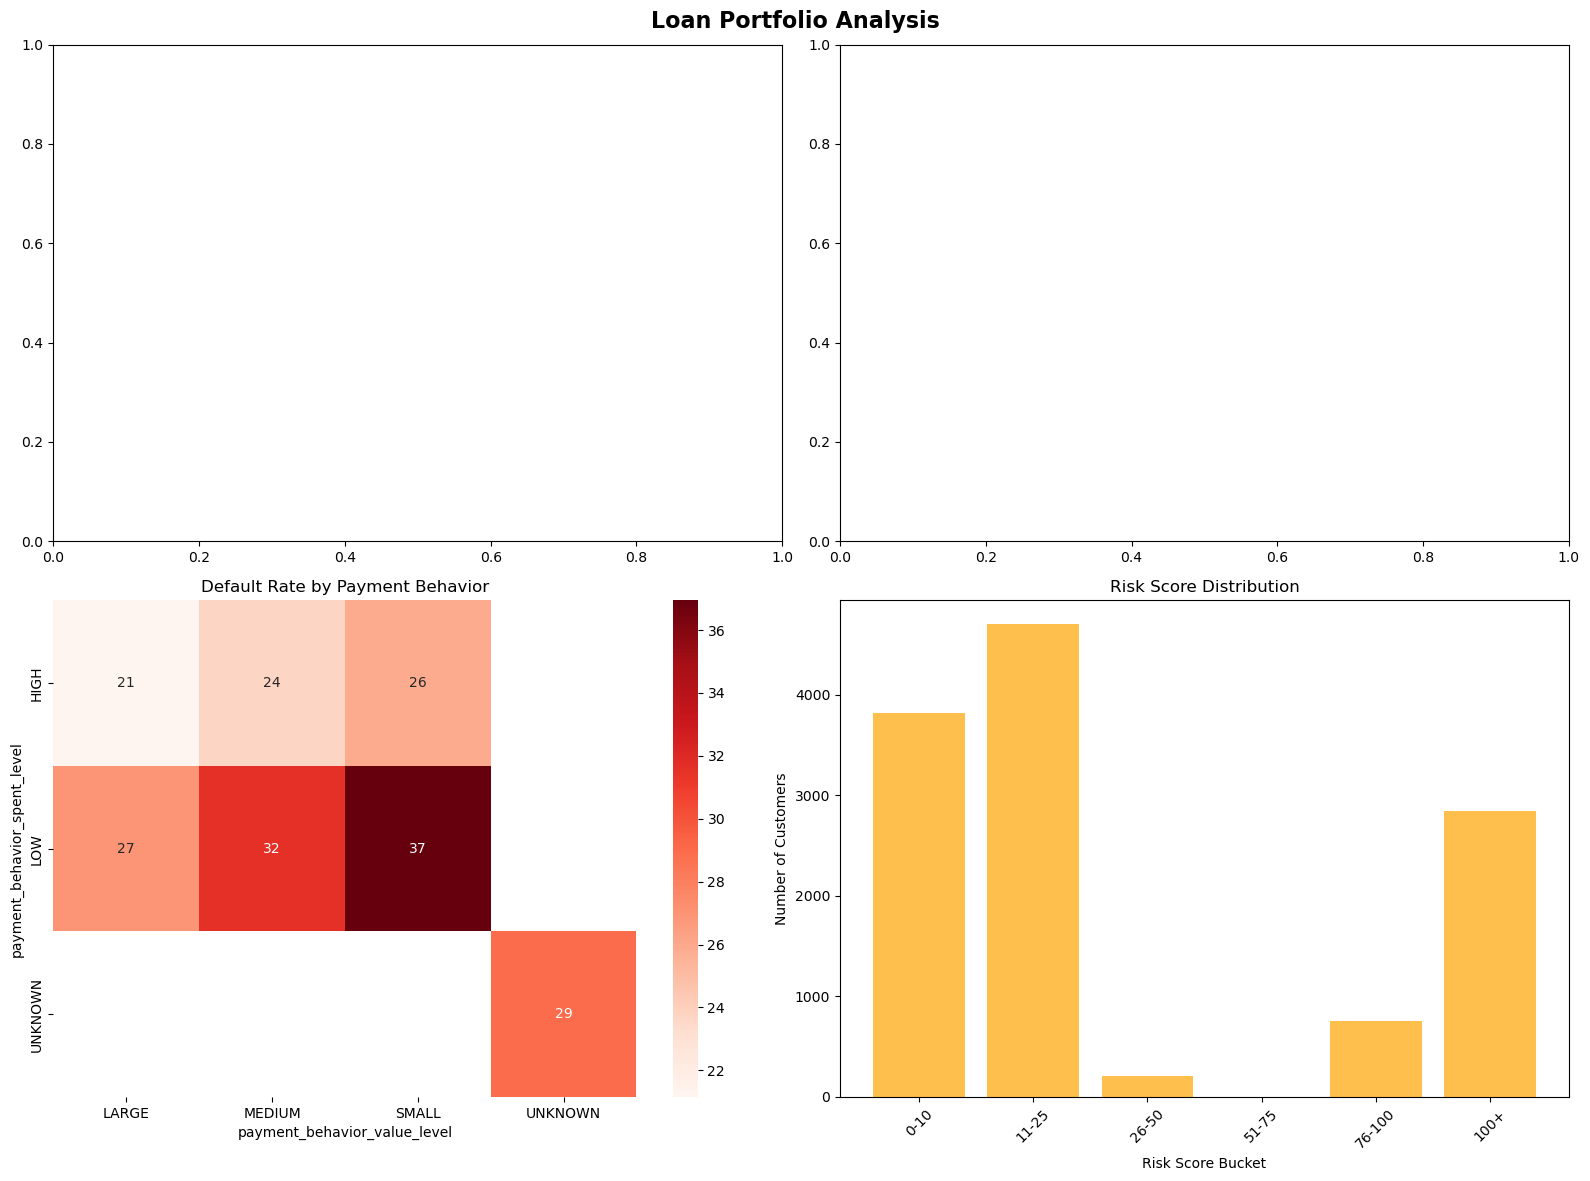


6. FEATURE CORRELATION AND IMPORTANCE ANALYSIS
-------------------------------------------------------


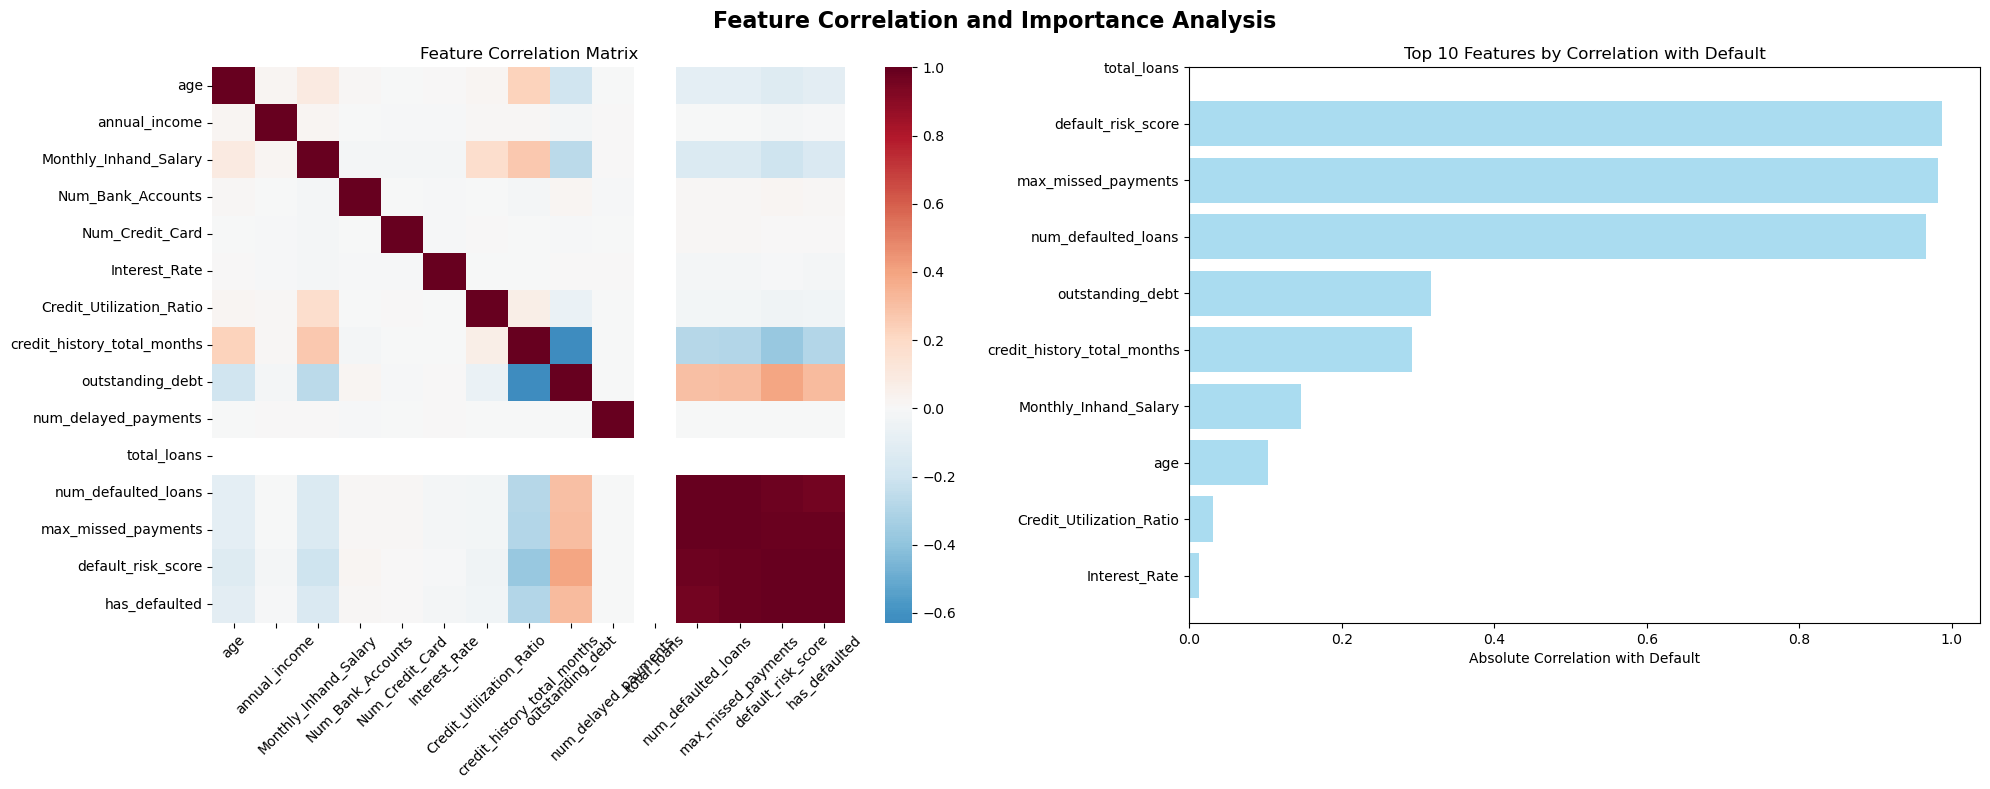


7. BUSINESS INSIGHTS AND SUMMARY
---------------------------------------------
KEY BUSINESS METRICS:
   • Total Customers: 12,500
   • Average Annual Income: $161,620.55
   • Average Credit Utilization: 32.35%
   • Average Credit History: 224.6 months
   • Overall Default Rate: 28.82%
   • Average Risk Score: 39.7
   • Customers with Clickstream Data: 8,974 (71.8%)

 HIGH-RISK CUSTOMER ANALYSIS:
   • High-risk customers (score > 100): 2,847 (22.8%)

DATA QUALITY ASSESSMENT:
   • Customers with missing age: 319 (2.6%)
   • Customers with imputed clickstream: 3,526 (28.2%)

GOLD LAYER EDA ANALYSIS COMPLETED
Key insights:
   1. Default rate and risk distribution analysis completed
   2. Customer segmentation by demographics and financial health identified
   3. Behavioral patterns from clickstream data analyzed
   4. Feature correlations and importance rankings established
   5. Data quality assessment confirms readiness for ML modeling


In [35]:
# ================================================================================================
# GOLD LAYER COMPREHENSIVE EDA ANALYSIS
# This analysis focuses on the final feature set for machine learning model development
# Includes customer segmentation, risk analysis, and feature importance evaluation
# ================================================================================================

from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set enhanced plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ================================================================================================
# DATA LOADING SECTION
# ================================================================================================

print("Loading Gold Layer Feature Data...")
print("-" * 40)

# Load the gold layer features dataset
try:
    gold_df = spark.read.parquet("datamart/gold/gold_features")
    print("Gold layer data loaded successfully!")
    
    # Basic information
    total_customers = gold_df.count()
    total_features = len(gold_df.columns)
    
    print(f"Dataset Overview:")
    print(f"   • Total customers: {total_customers:,}")
    print(f"   • Total features: {total_features}")
    
except Exception as e:
    print(f"Error loading gold layer data: {e}")
    print("Please ensure the gold layer data has been created successfully.")
    raise

print("\n" + "=" * 90)
print("GOLD LAYER COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
print("=" * 90)

# ================================================================================================
# 1. TARGET VARIABLE ANALYSIS
# ================================================================================================

print("\n1. TARGET VARIABLE ANALYSIS")
print("-" * 50)

# Get target variable statistics
target_stats = gold_df.groupBy("has_defaulted").agg(
    count("*").alias("customer_count"),
    avg("default_risk_score").alias("avg_risk_score"),
    stddev("default_risk_score").alias("stddev_risk_score"),
    min("default_risk_score").alias("min_risk_score"),
    max("default_risk_score").alias("max_risk_score")
).toPandas()

print("Target Variable Distribution:")
print(target_stats)

# Calculate key metrics
default_rate = target_stats[target_stats['has_defaulted'] == True]['customer_count'].values[0] / total_customers * 100
print(f"\n Key Metrics:")
print(f"   • Overall default rate: {default_rate:.2f}%")
print(f"   • Total defaulted customers: {target_stats[target_stats['has_defaulted'] == True]['customer_count'].values[0]:,}")
print(f"   • Total non-defaulted customers: {target_stats[target_stats['has_defaulted'] == False]['customer_count'].values[0]:,}")

# Visualization 1: Target Variable Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Target Variable Analysis', fontsize=16, fontweight='bold')

# Default distribution pie chart
default_counts = target_stats.set_index('has_defaulted')['customer_count']
colors = ['lightgreen', 'lightcoral']
axes[0,0].pie(default_counts.values, labels=['Non-Default', 'Default'], autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[0,0].set_title('Default Distribution')

# Risk score distribution by default status
risk_score_data = gold_df.select("has_defaulted", "default_risk_score").toPandas()
risk_score_data['default_status'] = risk_score_data['has_defaulted'].map({True: 'Default', False: 'Non-Default'})

sns.boxplot(data=risk_score_data, x='default_status', y='default_risk_score', ax=axes[0,1])
axes[0,1].set_title('Risk Score Distribution by Default Status')
axes[0,1].set_ylabel('Default Risk Score')

# Risk score histogram
axes[1,0].hist(risk_score_data[risk_score_data['has_defaulted']==False]['default_risk_score'], 
               bins=30, alpha=0.7, label='Non-Default', color='green', density=True)
axes[1,0].hist(risk_score_data[risk_score_data['has_defaulted']==True]['default_risk_score'], 
               bins=30, alpha=0.7, label='Default', color='red', density=True)
axes[1,0].set_title('Risk Score Distribution')
axes[1,0].set_xlabel('Default Risk Score')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()

# Risk score percentiles
risk_percentiles = gold_df.select("default_risk_score").summary("min", "25%", "50%", "75%", "max").toPandas()
percentile_values = [float(risk_percentiles.iloc[i, 1]) for i in range(5)]
percentile_labels = ['Min', '25%', '50%', '75%', 'Max']

axes[1,1].bar(percentile_labels, percentile_values, color='skyblue', alpha=0.7)
axes[1,1].set_title('Risk Score Percentiles')
axes[1,1].set_ylabel('Risk Score')
for i, v in enumerate(percentile_values):
    axes[1,1].text(i, v + 1, f'{v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ================================================================================================
# 2. DEMOGRAPHIC AND CUSTOMER ATTRIBUTES ANALYSIS
# ================================================================================================

print("\n2.DEMOGRAPHIC AND CUSTOMER ATTRIBUTES ANALYSIS")
print("-" * 60)

# Age analysis
age_analysis = gold_df.withColumn(
    "age_group",
    when(col("age") < 25, "18-24")
    .when(col("age") < 35, "25-34")
    .when(col("age") < 45, "35-44")
    .when(col("age") < 55, "45-54")
    .otherwise("55+")
).groupBy("age_group").agg(
    count("*").alias("customer_count"),
    avg("annual_income").alias("avg_income"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate"),
    avg("default_risk_score").alias("avg_risk_score")
).orderBy("age_group").toPandas()

print("Age Group Analysis:")
print(age_analysis)

# Occupation analysis
occupation_analysis = gold_df.groupBy("occupation").agg(
    count("*").alias("customer_count"),
    avg("annual_income").alias("avg_income"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate"),
    avg("default_risk_score").alias("avg_risk_score")
).orderBy(desc("customer_count")).limit(10).toPandas()

print("\nTop 10 Occupations Analysis:")
print(occupation_analysis)

# Visualization 2: Demographic Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Demographic and Customer Attributes Analysis', fontsize=16, fontweight='bold')

# Age group distribution and default rate
x_pos = np.arange(len(age_analysis))
ax1 = axes[0,0]
bars1 = ax1.bar(x_pos, age_analysis['customer_count'], alpha=0.7, color='lightblue')
ax1.set_title('Customer Distribution by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Number of Customers', color='blue')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(age_analysis['age_group'])

ax2 = ax1.twinx()
line1 = ax2.plot(x_pos, age_analysis['default_rate'], 'ro-', linewidth=2, markersize=8)
ax2.set_ylabel('Default Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Income distribution by age group
axes[0,1].bar(x_pos, age_analysis['avg_income'], alpha=0.7, color='lightgreen')
axes[0,1].set_title('Average Income by Age Group')
axes[0,1].set_xlabel('Age Group')
axes[0,1].set_ylabel('Average Annual Income ($)')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(age_analysis['age_group'])

# Top occupations by customer count
top_occupations = occupation_analysis.head(8)
axes[1,0].barh(range(len(top_occupations)), top_occupations['customer_count'], color='orange', alpha=0.7)
axes[1,0].set_title('Top Occupations by Customer Count')
axes[1,0].set_xlabel('Number of Customers')
axes[1,0].set_yticks(range(len(top_occupations)))
axes[1,0].set_yticklabels(top_occupations['occupation'])

# Default rate by occupation
axes[1,1].barh(range(len(top_occupations)), top_occupations['default_rate'], color='red', alpha=0.7)
axes[1,1].set_title('Default Rate by Occupation')
axes[1,1].set_xlabel('Default Rate (%)')
axes[1,1].set_yticks(range(len(top_occupations)))
axes[1,1].set_yticklabels(top_occupations['occupation'])

plt.tight_layout()
plt.show()

# ================================================================================================
# 3. FINANCIAL HEALTH ANALYSIS
# ================================================================================================

print("\n3.FINANCIAL HEALTH ANALYSIS")
print("-" * 40)

# Income analysis
income_buckets = gold_df.withColumn(
    "income_bucket",
    when(col("annual_income") < 30000, "< $30K")
    .when(col("annual_income") < 50000, "$30K - $50K")
    .when(col("annual_income") < 75000, "$50K - $75K")
    .when(col("annual_income") < 100000, "$75K - $100K")
    .otherwise("> $100K")
).groupBy("income_bucket").agg(
    count("*").alias("customer_count"),
    avg("Credit_Utilization_Ratio").alias("avg_credit_util"),
    avg("outstanding_debt").alias("avg_debt"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate")
).toPandas()

print("Income Bucket Analysis:")
print(income_buckets)

# Credit mix analysis
credit_mix_analysis = gold_df.groupBy("credit_mix").agg(
    count("*").alias("customer_count"),
    avg("annual_income").alias("avg_income"),
    avg("Credit_Utilization_Ratio").alias("avg_credit_util"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate")
).toPandas()

print("\nCredit Mix Analysis:")
print(credit_mix_analysis)

# Visualization 3: Financial Health Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Financial Health Analysis', fontsize=16, fontweight='bold')

# Income vs Default Rate
income_order = ["< $30K", "$30K - $50K", "$50K - $75K", "$75K - $100K", "> $100K"]
income_ordered = income_buckets.set_index('income_bucket').reindex(income_order)

x_pos = np.arange(len(income_order))
bars = axes[0,0].bar(x_pos, income_ordered['customer_count'], alpha=0.7, color='lightblue')
axes[0,0].set_title('Customer Distribution by Income Level')
axes[0,0].set_xlabel('Income Bucket')
axes[0,0].set_ylabel('Number of Customers')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(income_order, rotation=45)

# Credit utilization distribution
credit_util_data = gold_df.select("Credit_Utilization_Ratio", "has_defaulted").toPandas()
credit_util_data['default_status'] = credit_util_data['has_defaulted'].map({True: 'Default', False: 'Non-Default'})

sns.boxplot(data=credit_util_data, x='default_status', y='Credit_Utilization_Ratio', ax=axes[0,1])
axes[0,1].set_title('Credit Utilization by Default Status')
axes[0,1].set_ylabel('Credit Utilization Ratio')

# Outstanding debt analysis
debt_data = gold_df.select("outstanding_debt", "has_defaulted").toPandas()
debt_data['default_status'] = debt_data['has_defaulted'].map({True: 'Default', False: 'Non-Default'})

sns.violinplot(data=debt_data, x='default_status', y='outstanding_debt', ax=axes[1,0])
axes[1,0].set_title('Outstanding Debt Distribution')
axes[1,0].set_ylabel('Outstanding Debt ($)')

# Credit mix distribution
credit_mix_counts = credit_mix_analysis.set_index('credit_mix')['customer_count']
axes[1,1].pie(credit_mix_counts.values, labels=credit_mix_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Credit Mix Distribution')

plt.tight_layout()
plt.show()

# ================================================================================================
# 4. BEHAVIORAL FEATURES ANALYSIS (CLICKSTREAM)
# ================================================================================================

print("\n4. 🖱️ BEHAVIORAL FEATURES ANALYSIS")
print("-" * 40)

# Clickstream data coverage analysis
clickstream_coverage = gold_df.groupBy("has_clickstream_data").agg(
    count("*").alias("customer_count"),
    avg("annual_income").alias("avg_income"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate"),
    avg("default_risk_score").alias("avg_risk_score")
).toPandas()

print("Clickstream Data Coverage Analysis:")
print(clickstream_coverage)

# Analyze customers with clickstream data
clickstream_customers = gold_df.filter(col("has_clickstream_data") == True)

if clickstream_customers.count() > 0:
    # Feature analysis for customers with clickstream data
    clickstream_features = ['fe_1_mean', 'fe_2_mean', 'fe_3_mean', 'fe_4_mean', 'fe_5_mean']
    
    clickstream_stats = clickstream_customers.select(
        *clickstream_features + ["has_defaulted"]
    ).toPandas()
    
    # Visualization 4: Behavioral Features Analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🖱️ Behavioral Features Analysis', fontsize=16, fontweight='bold')
    
    # Clickstream coverage
    coverage_counts = clickstream_coverage.set_index('has_clickstream_data')['customer_count']
    axes[0,0].pie(coverage_counts.values, labels=['No Clickstream', 'Has Clickstream'], 
                  autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
    axes[0,0].set_title('Clickstream Data Coverage')
    
    # Default rate by clickstream availability
    axes[0,1].bar(['No Clickstream', 'Has Clickstream'], clickstream_coverage['default_rate'], 
                  color=['lightcoral', 'lightgreen'], alpha=0.7)
    axes[0,1].set_title('Default Rate by Clickstream Availability')
    axes[0,1].set_ylabel('Default Rate (%)')
    
    # Clickstream features correlation
    if len(clickstream_stats) > 100:  # Only if we have enough data
        feature_corr = clickstream_stats[clickstream_features].corr()
        sns.heatmap(feature_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
        axes[1,0].set_title('Clickstream Features Correlation')
    
        # Feature importance (simplified)
        default_mapping = {True: 1, False: 0}
        clickstream_stats['default_numeric'] = clickstream_stats['has_defaulted'].map(default_mapping)
        
        feature_importance = []
        for feature in clickstream_features:
            correlation = clickstream_stats[feature].corr(clickstream_stats['default_numeric'])
            feature_importance.append(np.abs(correlation))  # Use numpy abs instead of PySpark abs
        
        axes[1,1].bar(range(len(clickstream_features)), feature_importance, 
                      color='skyblue', alpha=0.7)
        axes[1,1].set_title('Clickstream Feature Importance (Correlation with Default)')
        axes[1,1].set_xlabel('Features')
        axes[1,1].set_ylabel('Absolute Correlation')
        axes[1,1].set_xticks(range(len(clickstream_features)))
        axes[1,1].set_xticklabels([f'FE_{i+1}' for i in range(len(clickstream_features))])
    
    plt.tight_layout()
    plt.show()

# ================================================================================================
# 5. LOAN PORTFOLIO ANALYSIS
# ================================================================================================

print("\n5. LOAN PORTFOLIO ANALYSIS")
print("-" * 35)

# Loan performance analysis
loan_analysis = gold_df.groupBy("total_loans").agg(
    count("*").alias("customer_count"),
    avg("num_defaulted_loans").alias("avg_defaulted_loans"),
    avg("max_missed_payments").alias("avg_max_missed_payments"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate")
).orderBy("total_loans").toPandas()

print("Loan Portfolio Analysis:")
print(loan_analysis)

# Payment behavior analysis
payment_behavior_analysis = gold_df.groupBy("payment_behavior_spent_level", "payment_behavior_value_level").agg(
    count("*").alias("customer_count"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate"),
    avg("default_risk_score").alias("avg_risk_score")
).toPandas()

print("\nPayment Behavior Analysis:")
print(payment_behavior_analysis.head(10))

# Visualization 5: Loan Portfolio Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Loan Portfolio Analysis', fontsize=16, fontweight='bold')

# Loans per customer distribution
if len(loan_analysis) > 1:
    axes[0,0].bar(loan_analysis['total_loans'], loan_analysis['customer_count'], 
                  color='lightblue', alpha=0.7)
    axes[0,0].set_title('Distribution of Loans per Customer')
    axes[0,0].set_xlabel('Number of Loans')
    axes[0,0].set_ylabel('Number of Customers')

# Default rate by number of loans
if len(loan_analysis) > 1:
    axes[0,1].plot(loan_analysis['total_loans'], loan_analysis['default_rate'], 
                   'ro-', linewidth=2, markersize=8)
    axes[0,1].set_title('Default Rate by Number of Loans')
    axes[0,1].set_xlabel('Number of Loans')
    axes[0,1].set_ylabel('Default Rate (%)')

# Payment behavior heatmap
if len(payment_behavior_analysis) > 5:
    payment_pivot = payment_behavior_analysis.pivot(index='payment_behavior_spent_level', 
                                                    columns='payment_behavior_value_level', 
                                                    values='default_rate')
    sns.heatmap(payment_pivot, annot=True, cmap='Reds', ax=axes[1,0])
    axes[1,0].set_title('Default Rate by Payment Behavior')

# Risk score distribution
risk_bins = [0, 10, 25, 50, 75, 100, 150]
risk_labels = ['0-10', '11-25', '26-50', '51-75', '76-100', '100+']

risk_data = gold_df.select("default_risk_score").toPandas()
risk_data['risk_bucket'] = pd.cut(risk_data['default_risk_score'], bins=risk_bins, labels=risk_labels)
risk_distribution = risk_data['risk_bucket'].value_counts().sort_index()

axes[1,1].bar(range(len(risk_distribution)), risk_distribution.values, 
              color='orange', alpha=0.7)
axes[1,1].set_title('Risk Score Distribution')
axes[1,1].set_xlabel('Risk Score Bucket')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_xticks(range(len(risk_distribution)))
axes[1,1].set_xticklabels(risk_distribution.index, rotation=45)

plt.tight_layout()
plt.show()

# ================================================================================================
# 6. FEATURE CORRELATION AND IMPORTANCE ANALYSIS
# ================================================================================================

print("\n6. FEATURE CORRELATION AND IMPORTANCE ANALYSIS")
print("-" * 55)

# Select key numerical features for correlation analysis
key_features = [
    'age', 'annual_income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 
    'Num_Credit_Card', 'Interest_Rate', 'Credit_Utilization_Ratio',
    'credit_history_total_months', 'outstanding_debt', 'num_delayed_payments',
    'total_loans', 'num_defaulted_loans', 'max_missed_payments', 'default_risk_score'
]

# Get correlation data
correlation_data = gold_df.select(key_features + ['has_defaulted']).toPandas()
correlation_data['has_defaulted'] = correlation_data['has_defaulted'].astype(int)

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Visualization 6: Feature Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Feature Correlation and Importance Analysis', fontsize=16, fontweight='bold')

# Correlation heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='RdBu_r', center=0, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Feature importance with target variable
target_correlations = correlation_matrix['has_defaulted'].drop('has_defaulted').abs().sort_values(ascending=True)
top_features = target_correlations.tail(10)

axes[1].barh(range(len(top_features)), top_features.values, color='skyblue', alpha=0.7)
axes[1].set_title('Top 10 Features by Correlation with Default')
axes[1].set_xlabel('Absolute Correlation with Default')
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features.index)

plt.tight_layout()
plt.show()

# ================================================================================================
# 7. BUSINESS INSIGHTS AND SUMMARY
# ================================================================================================

print("\n7. BUSINESS INSIGHTS AND SUMMARY")
print("-" * 45)

# Calculate key business metrics
business_metrics = gold_df.agg(
    count("*").alias("total_customers"),
    avg("annual_income").alias("avg_income"),
    avg("Credit_Utilization_Ratio").alias("avg_credit_util"),
    avg("credit_history_total_months").alias("avg_credit_history"),
    (sum(when(col("has_defaulted") == True, 1).otherwise(0)) / count("*") * 100).alias("default_rate"),
    avg("default_risk_score").alias("avg_risk_score"),
    sum(when(col("has_clickstream_data") == True, 1).otherwise(0)).alias("customers_with_clickstream"),
    avg("num_defaulted_loans").alias("avg_defaulted_loans")
).collect()[0]

print("KEY BUSINESS METRICS:")
print(f"   • Total Customers: {business_metrics['total_customers']:,}")
print(f"   • Average Annual Income: ${business_metrics['avg_income']:,.2f}")
print(f"   • Average Credit Utilization: {business_metrics['avg_credit_util']:.2f}%")
print(f"   • Average Credit History: {business_metrics['avg_credit_history']:.1f} months")
print(f"   • Overall Default Rate: {business_metrics['default_rate']:.2f}%")
print(f"   • Average Risk Score: {business_metrics['avg_risk_score']:.1f}")
print(f"   • Customers with Clickstream Data: {business_metrics['customers_with_clickstream']:,} ({business_metrics['customers_with_clickstream']/business_metrics['total_customers']*100:.1f}%)")

# High-risk customer analysis
high_risk_customers = gold_df.filter(col("default_risk_score") > 100).count()
high_risk_rate = (high_risk_customers / total_customers) * 100

print(f"\n HIGH-RISK CUSTOMER ANALYSIS:")
print(f"   • High-risk customers (score > 100): {high_risk_customers:,} ({high_risk_rate:.1f}%)")

# Data quality assessment
missing_age = gold_df.filter(col("age").isNull()).count()
imputed_clickstream = gold_df.filter(col("clickstream_features_imputed") == True).count()

print(f"\nDATA QUALITY ASSESSMENT:")
print(f"   • Customers with missing age: {missing_age:,} ({missing_age/total_customers*100:.1f}%)")
print(f"   • Customers with imputed clickstream: {imputed_clickstream:,} ({imputed_clickstream/total_customers*100:.1f}%)")

print("\n" + "=" * 90)
print("GOLD LAYER EDA ANALYSIS COMPLETED")
print("Key insights:")
print("   1. Default rate and risk distribution analysis completed")
print("   2. Customer segmentation by demographics and financial health identified")
print("   3. Behavioral patterns from clickstream data analyzed")
print("   4. Feature correlations and importance rankings established")
print("   5. Data quality assessment confirms readiness for ML modeling")
print("=" * 90)